In [3]:
import numpy as np
import matplotlib
import pandas as pd
from sklearn.model_selection import train_test_split


dataset = pd.read_csv('/Users/eddie/Downloads/Agriculture Data.xlsx - Sheet1.csv')

X = pd.DataFrame(dataset.iloc[:,0:11].values)
Y = pd.DataFrame(dataset.iloc[:,11:].values)
print(X)
print(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=0)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(Y_train.shape)

features = pd.DataFrame(dataset.iloc[:,0:11])
features = features.columns
print(features)

      0   1   2   3   4   5   6   7   8   9   10
0      3   2   2  25  26   9   0   0   0   0   0
1      3   3   1  61  17   9   0   0   0   0   0
2      3   3   1  65  16   9   0   0   0   0   0
3      3   2   1  49  17   9   0   0   0   1   0
4      3   1   1  59  28   9   0   0   0   0   0
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
2416   1   1   1  50  25   9   0   0   0   0   0
2417   1   2   1  58  49   8   0   0   0   0   0
2418   1   2   1   3  36   9   0   0   0   0   0
2419   3   2   2  48  40   9   0   0   0   0   0
2420   1   1   1  81  37   7   0   0   0   0   0

[2421 rows x 11 columns]
      0
0     0
1     1
2     1
3     0
4     1
...  ..
2416  1
2417  0
2418  1
2419  0
2420  1

[2421 rows x 1 columns]
(1936, 11)
(1936, 1)
Index(['Location of Incident', 'Time', 'Sex', 'Age', 'State', 'Injury Agent ',
       'Confined Space', 'Grain Involved', 'Alcohol/Drugs', 'Seatbelt',
       'Helmet'],
      dtype='object')


In [4]:
from keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, GRU, LayerNormalization, MultiHeadAttention,TimeDistributed, Input, Flatten
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from time import time
import numpy as np
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

In [5]:

pbounds = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (100, 1000),
    'max_depth': (3,10),
    'subsample': (1.0, 1.0),  # Change for big datasets
    'colsample': (1.0, 1.0),  # Change for datasets with lots of features
    'gamma': (0, 5)}

def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        subsample,
                        colsample,
                        gamma):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    clf = XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma)
    return np.mean(cross_val_score(clf, X_train, Y_train, cv=10, scoring='roc_auc'))

optimizer = BayesianOptimization(
    f=xgboost_hyper_param,
    pbounds=pbounds,
    random_state=1,
)
optimizer.maximize(init_points=5, n_iter=15)
best_params = optimizer.max['params']

|   iter    |  target   | colsample |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.6096    | 1.0       | 3.602     | 0.01011   | 5.116     | 232.1     | 1.0       |
| 2         | 0.6056    | 1.0       | 1.728     | 0.4028    | 6.772     | 477.3     | 1.0       |
| 3         | 0.6053    | 1.0       | 4.391     | 0.03711   | 7.693     | 475.6     | 1.0       |
| 4         | 0.5849    | 1.0       | 0.9905    | 0.8027    | 9.778     | 382.1     | 1.0       |
| 5         | 0.6136    | 1.0       | 4.473     | 0.09419   | 3.273     | 252.8     | 1.0       |
| 6         | 0.6135    | 1.0       | 4.974     | 0.07663   | 3.485     | 575.6     | 1.0       |
| 7         | 0.6067    | 1.0       | 0.3268    | 0.4184    | 4.112     | 652.8     | 1.0       |
| 8         | 0.6137    | 1.0       | 5.0       | 0.01      | 3.0       | 1e+03     | 1.0       |
| 9         | 0.6043

In [6]:
model = XGBClassifier(n_estimators=int(best_params['n_estimators']),
                                   gamma=best_params['gamma'],
                                   learning_rate=best_params['learning_rate'],
                                   max_depth=int(best_params['max_depth']),
                                   random_state=42)
model.fit(X_train,Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [7]:
res = model.predict(X_test)
print(Y_test)

from sklearn.metrics import classification_report
print(classification_report(Y_test,res,digits=6))

      0
1931  1
905   1
981   1
1923  1
758   0
...  ..
1721  1
259   0
1985  0
30    1
2026  1

[485 rows x 1 columns]
              precision    recall  f1-score   support

           0   0.750000  0.020833  0.040541       144
           1   0.706861  0.997067  0.827251       341

    accuracy                       0.707216       485
   macro avg   0.728430  0.508950  0.433896       485
weighted avg   0.719669  0.707216  0.593671       485



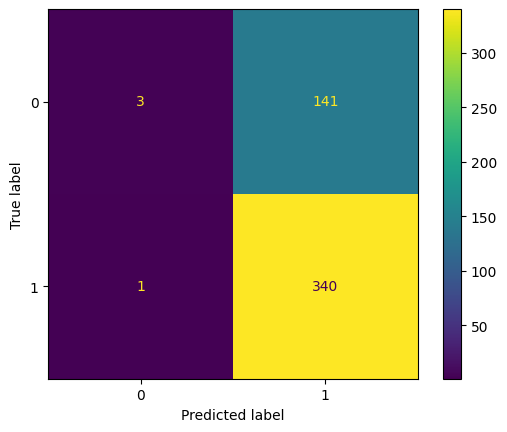

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
confusionmatrix = confusion_matrix(Y_test, res)
cm_display = ConfusionMatrixDisplay(confusionmatrix, display_labels=[0,1])
cm_display.plot()

c:\Users\eddie\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


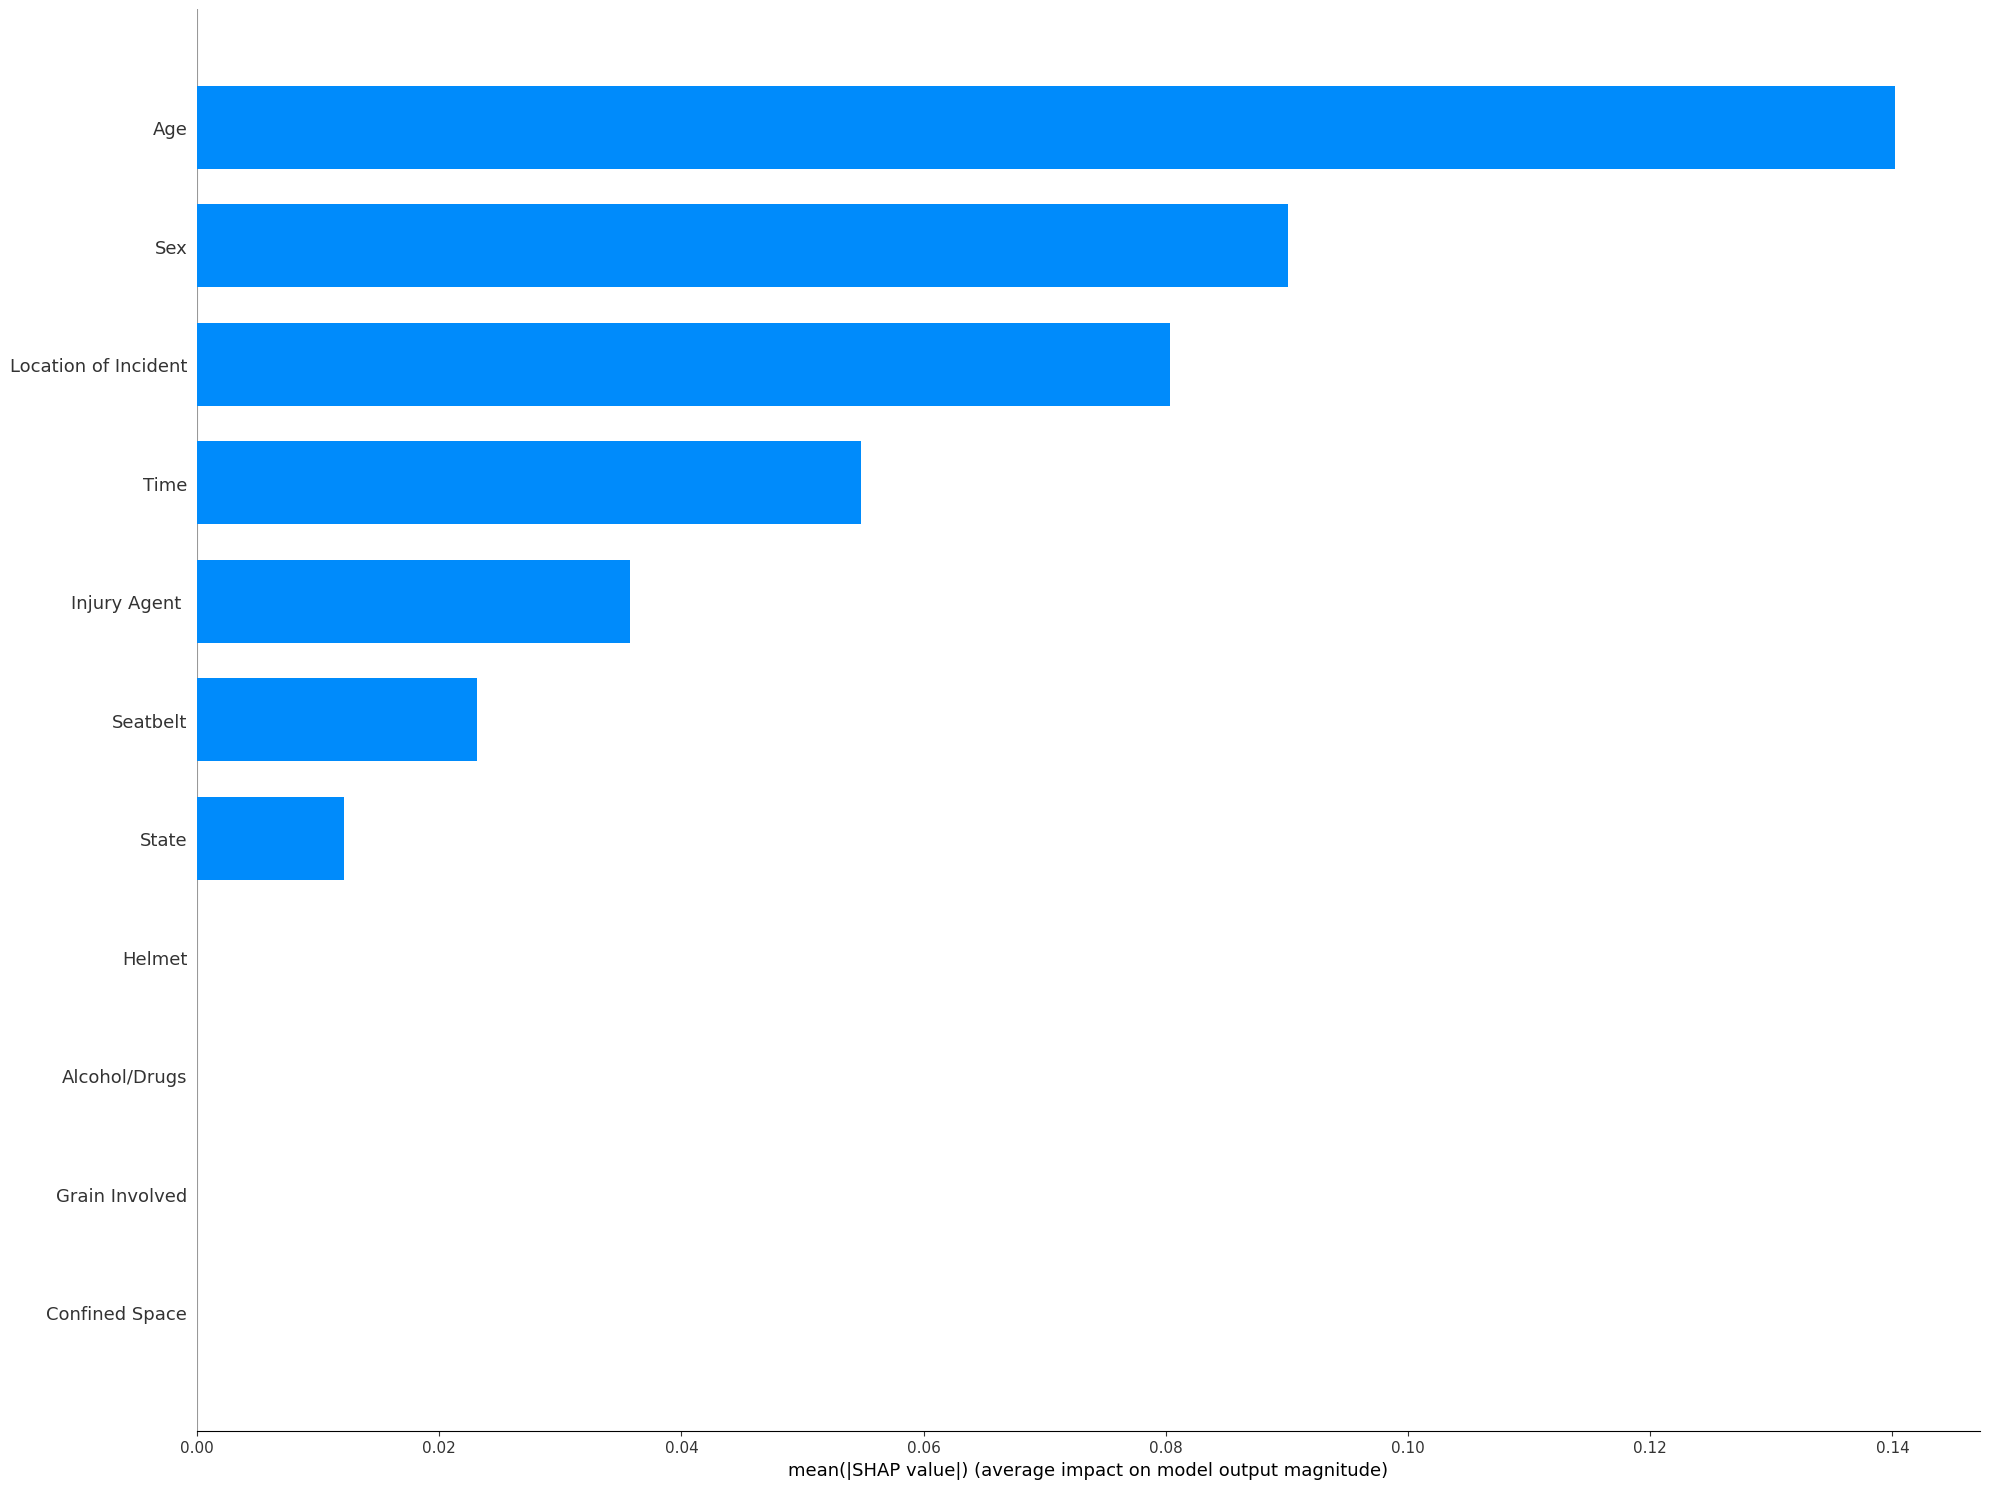

In [9]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test,feature_names = features,plot_size=(20,15),plot_type="bar",show=False)